In [1]:
import uproot
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, schemas
from coffea import processor, hist

## Define a Processor instance

The processor implementation given below has been taken from [here](https://github.com/CoffeaTeam/coffea/blob/master/binder/nanoevents.ipynb).

In [2]:
class MyZPeak(processor.ProcessorABC):
    def __init__(self):
        self._histo = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("mass", "Z mass", 60, 60, 120),
        )
    
    @property
    def accumulator(self):
        return self._histo
    
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        mmevents = events[
            (ak.num(events.Muon) == 2)
            & (ak.sum(events.Muon.charge, axis=1) == 0)
        ]
        zmm = mmevents.Muon[:, 0] + mmevents.Muon[:, 1]
        out.fill(
            dataset=events.metadata["dataset"],
            mass=zmm.mass,
        )
        return out
    
    def postprocess(self, accumulator):
        return accumulator

## Write some NanoEvents Parquet files to CephFS

Here we populate the CephFS mounted directory with the parquet files created in the previous step. In this version, we need to make sure that the individual file sizes is under 4MB which is the default object size of Ceph to ensure one-to-one mapping of files to objects, which is a requirement in the multiple-file design that we have now.

In [3]:
import os, shutil

if not os.path.isfile("nano_dy.parquet"):
    ak.to_parquet(
        uproot.lazy("nano_dy.root:Events"),
        "nano_dy.parquet",
        list_to32=True,
        use_dictionary=False,
        compression="GZIP",
        compression_level=1,
    )

if not os.path.isfile("nano_dimuon.parquet"):
    ak.to_parquet(
        uproot.lazy("nano_dimuon.root:Events"),
        "nano_dimuon.parquet",
        list_to32=True,
        use_dictionary=False,
        compression="GZIP",
        compression_level=1,
    )
    
if not os.path.isdir("/mnt/cephfs/nanoevents/ZJets"):
    os.makedirs("/mnt/cephfs/nanoevents/ZJets")
    for i in range(2):
        shutil.copyfile('nano_dy.parquet', '/mnt/cephfs/nanoevents/ZJets/nano_dy.{}.parquet'.format(i))
        
    
if not os.path.isdir("/mnt/cephfs/nanoevents/Data"):
    os.makedirs("/mnt/cephfs/nanoevents/Data")
    for i in range(2):
        shutil.copyfile('nano_dimuon.parquet', '/mnt/cephfs/nanoevents/Data/nano_dimuon.{}.parquet'.format(i))

## Running a job in parallel using Dask

The `LocalCluster()` used below creates a process pool with worker count equal to the number of cores available to the Notebook where each worker is single-threaded. The `LocalCluster` can be replaced by other cluster resource managers provided by Dask Distributed like `KuberneresCluster`, `YarnCluster`, etc. Here, we create a `LocalCluster` and get a client handle to it.

In [4]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34139")
client

<Client: 'tcp://127.0.0.1:34139' processes=1 threads=4, memory=15.70 GiB>

We have added a new function called `run_parquet_job` to the executor API in coffea to run jobs on Parquet files using the Arrow Dataset API under the hood. 
This API takes an optional `ceph_config_path` parameter, which is basically the path to the configuration file of the Ceph cluster and instructs this function to read from RADOS using the `SkyhookFileFormat` (which allows pushdown) instead of the out of the box `ParquetFormat` API . This API also allows just passing a single directory path and the Datasets API does the dataset discovery task by itself. The calls to the Dataset API are launced in parallel and there will one Dataset API call per file.

In [5]:
%%time

run = processor.Runner(
    executor=processor.DaskExecutor(client=client),
    use_skyhook=True,
    format="parquet",
    schema=schemas.NanoAODSchema,
)

hists = run(
    {
        "ZJets": "/mnt/cephfs/nanoevents/ZJets/",
        "Data": "/mnt/cephfs/nanoevents/Data",
    },
    "Events",
    processor_instance=MyZPeak(),
)

CPU times: user 645 ms, sys: 114 ms, total: 759 msCompleted |  7.4s
Wall time: 8 s


## Running iteratively using the `FuturesExecutor`

Run the same job again, but now iteratively. The calls to the Dataset API will now be sequential.

In [6]:
%%time

run = processor.Runner(
    executor=processor.FuturesExecutor(compression=None),
    use_skyhook=True,
    format="parquet",
    schema=schemas.NanoAODSchema,
)

hists = run(
    {
        "ZJets": "/mnt/cephfs/nanoevents/ZJets",
        "Data": "/mnt/cephfs/nanoevents/Data",
    },
    "Events",
    processor_instance=MyZPeak(),
)

Output()

/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(


CPU times: user 496 ms, sys: 53.8 ms, total: 550 ms
Wall time: 8.55 s


## Running iteratively without Skyhook `FuturesExecutor`

Run the same job again, but now iteratively without Skyhook. The calls to the Dataset API will now be sequential.

In [7]:
%%time

run = processor.Runner(
    executor=processor.IterativeExecutor(compression=None),
    use_skyhook=False,
    format="parquet",
    schema=schemas.NanoAODSchema,
)

hists = run(
    {
        "ZJets": "/mnt/cephfs/nanoevents/ZJets",
        "Data": "/mnt/cephfs/nanoevents/Data",
    },
    "Events",
    processor_instance=MyZPeak(),
)

Output()

/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: 
RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(

/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: 
RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(

CPU times: user 6.43 s, sys: 174 ms, total: 6.61 s
Wall time: 6.59 s


As expected, much slower than running using Dask.

## Running `DaskExecutor` without Skyhook

Run the same job again, but with `DaskExecutor` abd without Skyhook:

In [8]:
%%time

run = processor.Runner(
    executor=processor.DaskExecutor(client=client),
    use_skyhook=False,
    format="parquet",
    schema=schemas.NanoAODSchema,
)

hists = run(
    {
        "ZJets": "/mnt/cephfs/nanoevents/ZJets",
        "Data": "/mnt/cephfs/nanoevents/Data",
    },
    "Events",
    processor_instance=MyZPeak(),
)

CPU times: user 184 ms, sys: 23.5 ms, total: 208 msompleted |  4.4s
Wall time: 4.49 s


## Plotting the results



/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


<AxesSubplot:xlabel='Z mass', ylabel='Events'>

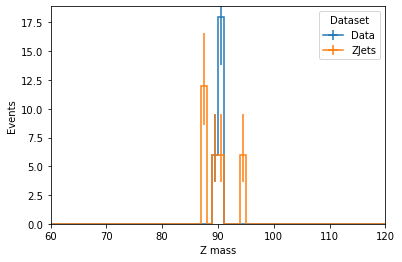

In [9]:
%matplotlib inline

hist.plot1d(hists)